# Movie Sentiment Analysis

Film Junky Union, a new community for classic film fans is developing a system to filter and categorize film reviews. Its main mission is to train a model to automatically detect negative reviews. You will use a *dataset* of IMBD movie reviews with polarity labeling to create a model that can classify positive and negative reviews. This model must have at least an F1 score of 0.85.

# Table of Contents:
1. Inisialisasi
2. Load Data
3. EDA
4. Evaluation Procedure
5. Normalisation
6. Train Test Split
7. Work with Model
8. Review
9. Conclusion

## Inisialisasi

In [1]:
import math
import re
import nltk

import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
lemmatizer = WordNetLemmatizer()

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [6]:
#Mengecek informasi umum
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
#Mengecek apakah terdapat nilai yang hilang
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [8]:
#Membuang nilai yang hilang karena hanya ada 4 data
df_reviews = df_reviews.dropna()
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
#Mengecek apakah terdapat nilai duplikat
df_reviews.duplicated().sum()

0

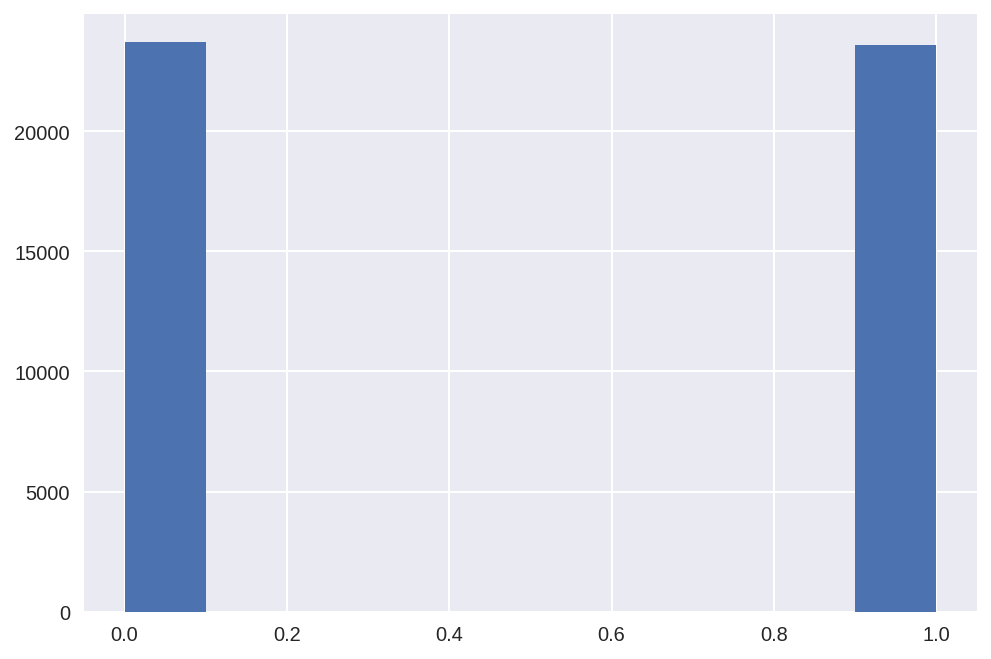

In [10]:
#Mengecek keseimbangan kelas
df_reviews['pos'].hist()
plt.show()

The data we have turns out to have a balanced class balance. The value 0 means negative and 1 means positive.

## EDA

Check the number of films and reviews over several years.

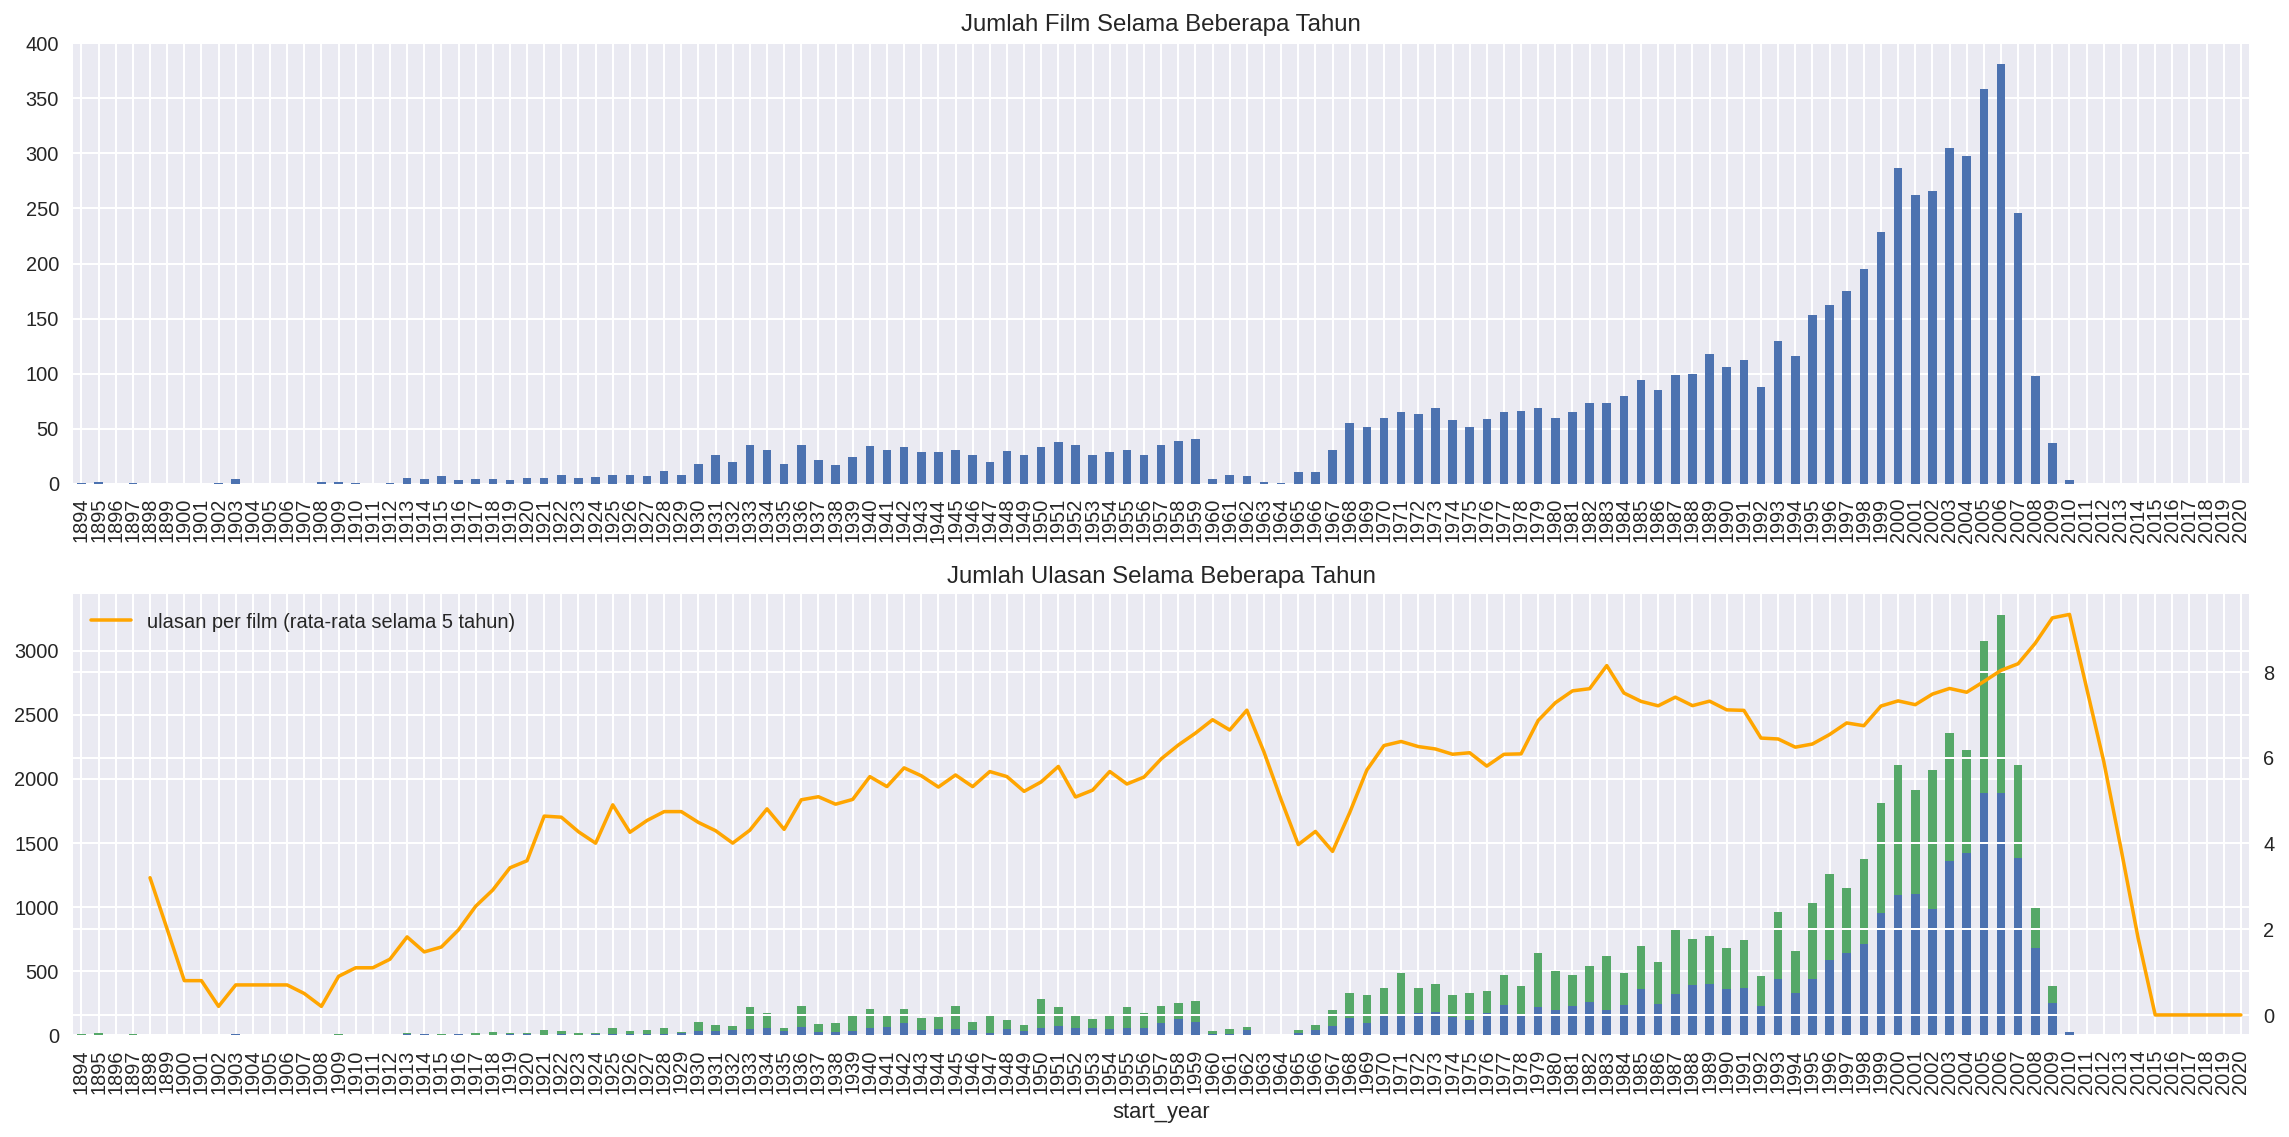

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

From the diagram above, it can be seen that the number of films released in 2006 was the highest, as well as the highest number of reviews for films released in 2006.

Check the distribution of the number of reviews per movie with exact counting and KDE (just to see how it differs from exact counting)

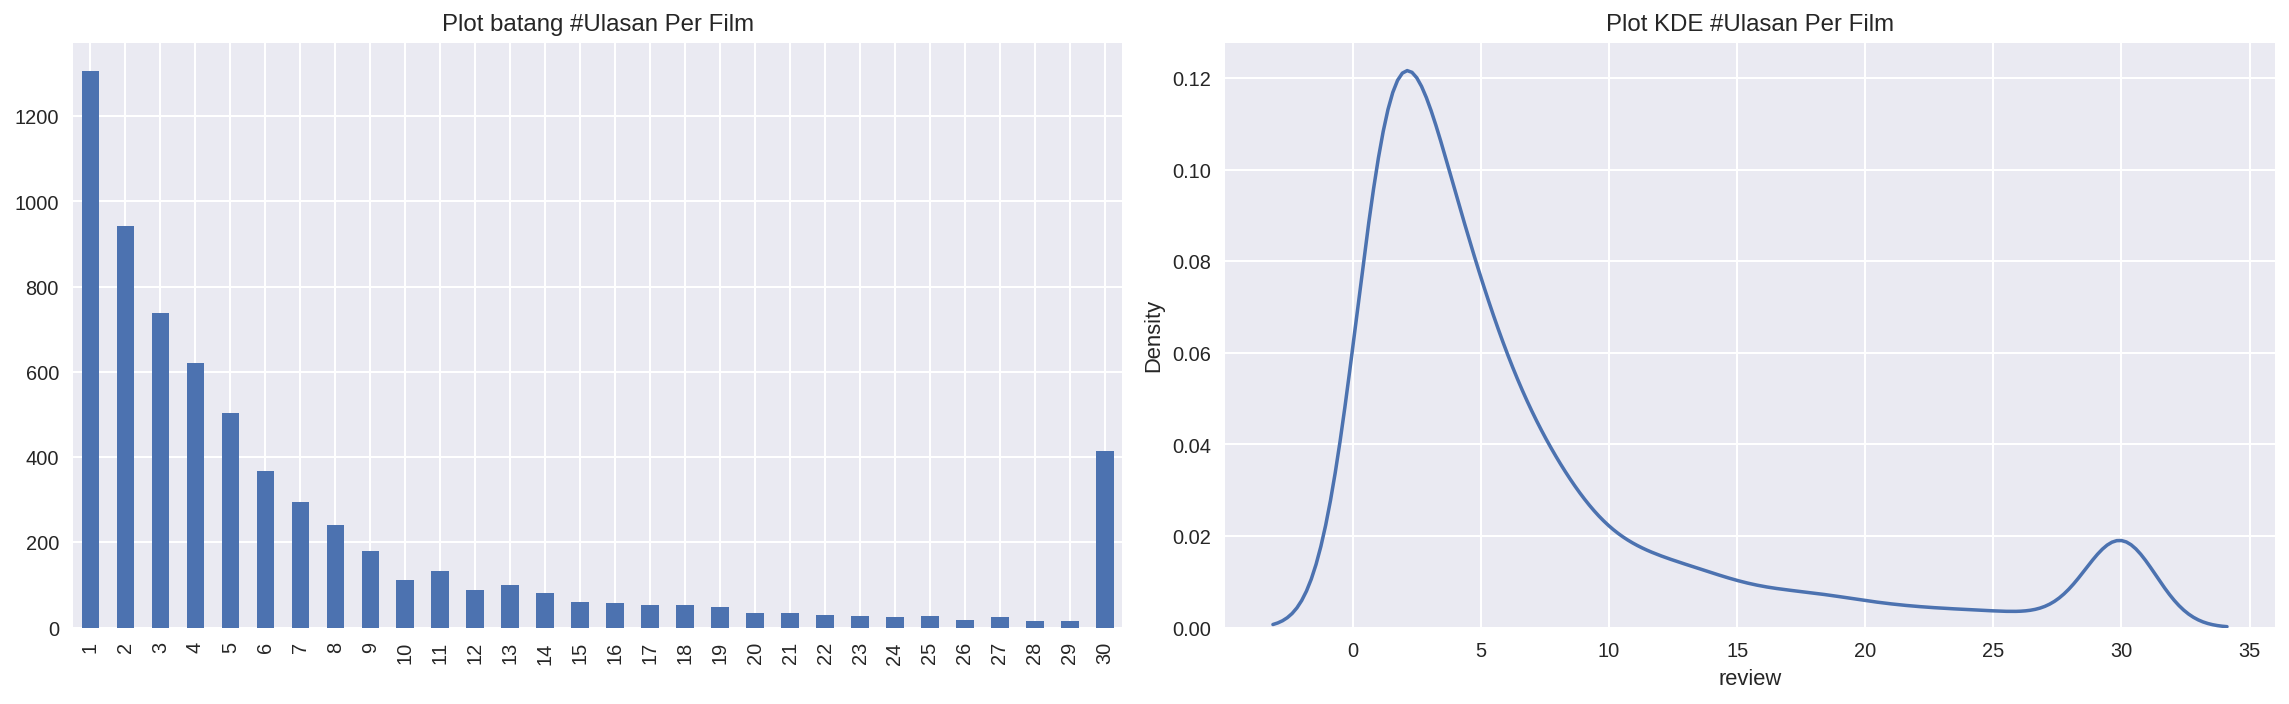

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

There are many films that have more than 1 review, from the plot above the number of film reviews has decreased and there is a significant increase, namely there are more than 400 films that have 30 reviews.

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

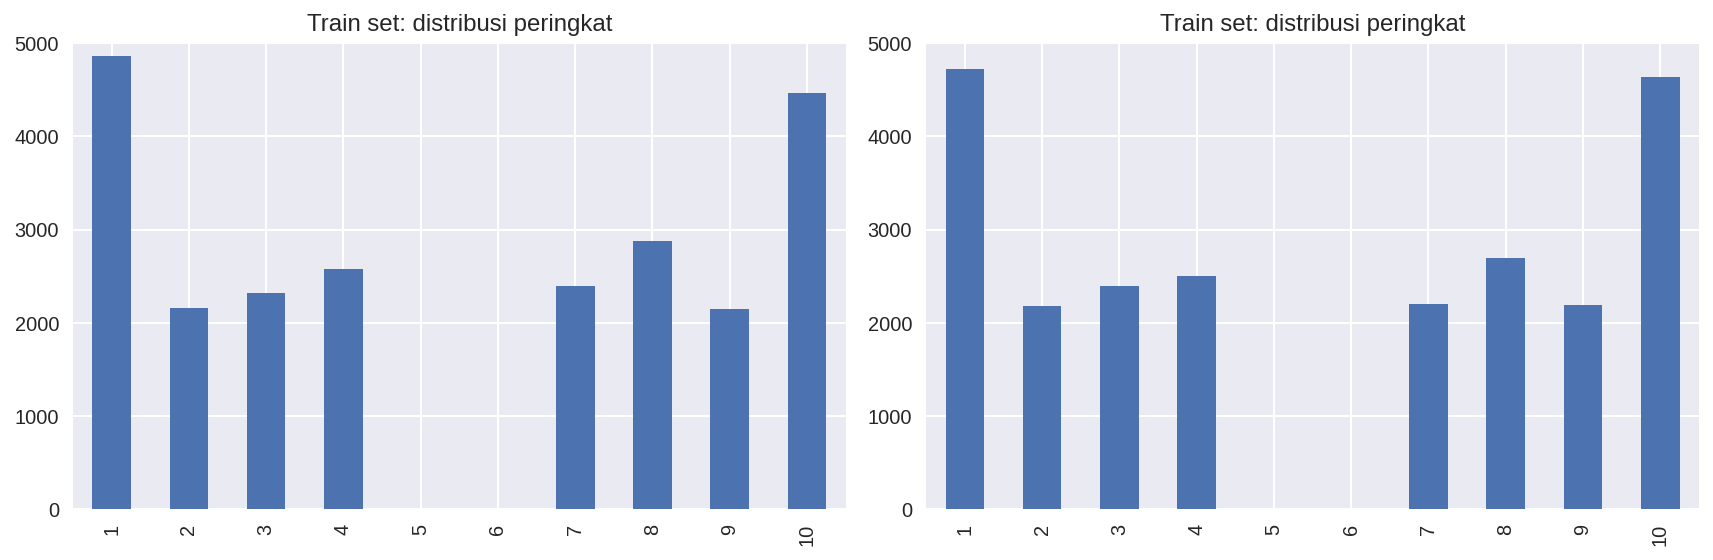

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

If you look at the rating graph above, the film with a rating of 1 is the highest, followed by a rating of 10. Meanwhile, the numbers for ratings 2, 3, 4, 7, 8 and 9 are not too different.

Distribution of negative and positive reviews over the years for the two parts of the *dataset*

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


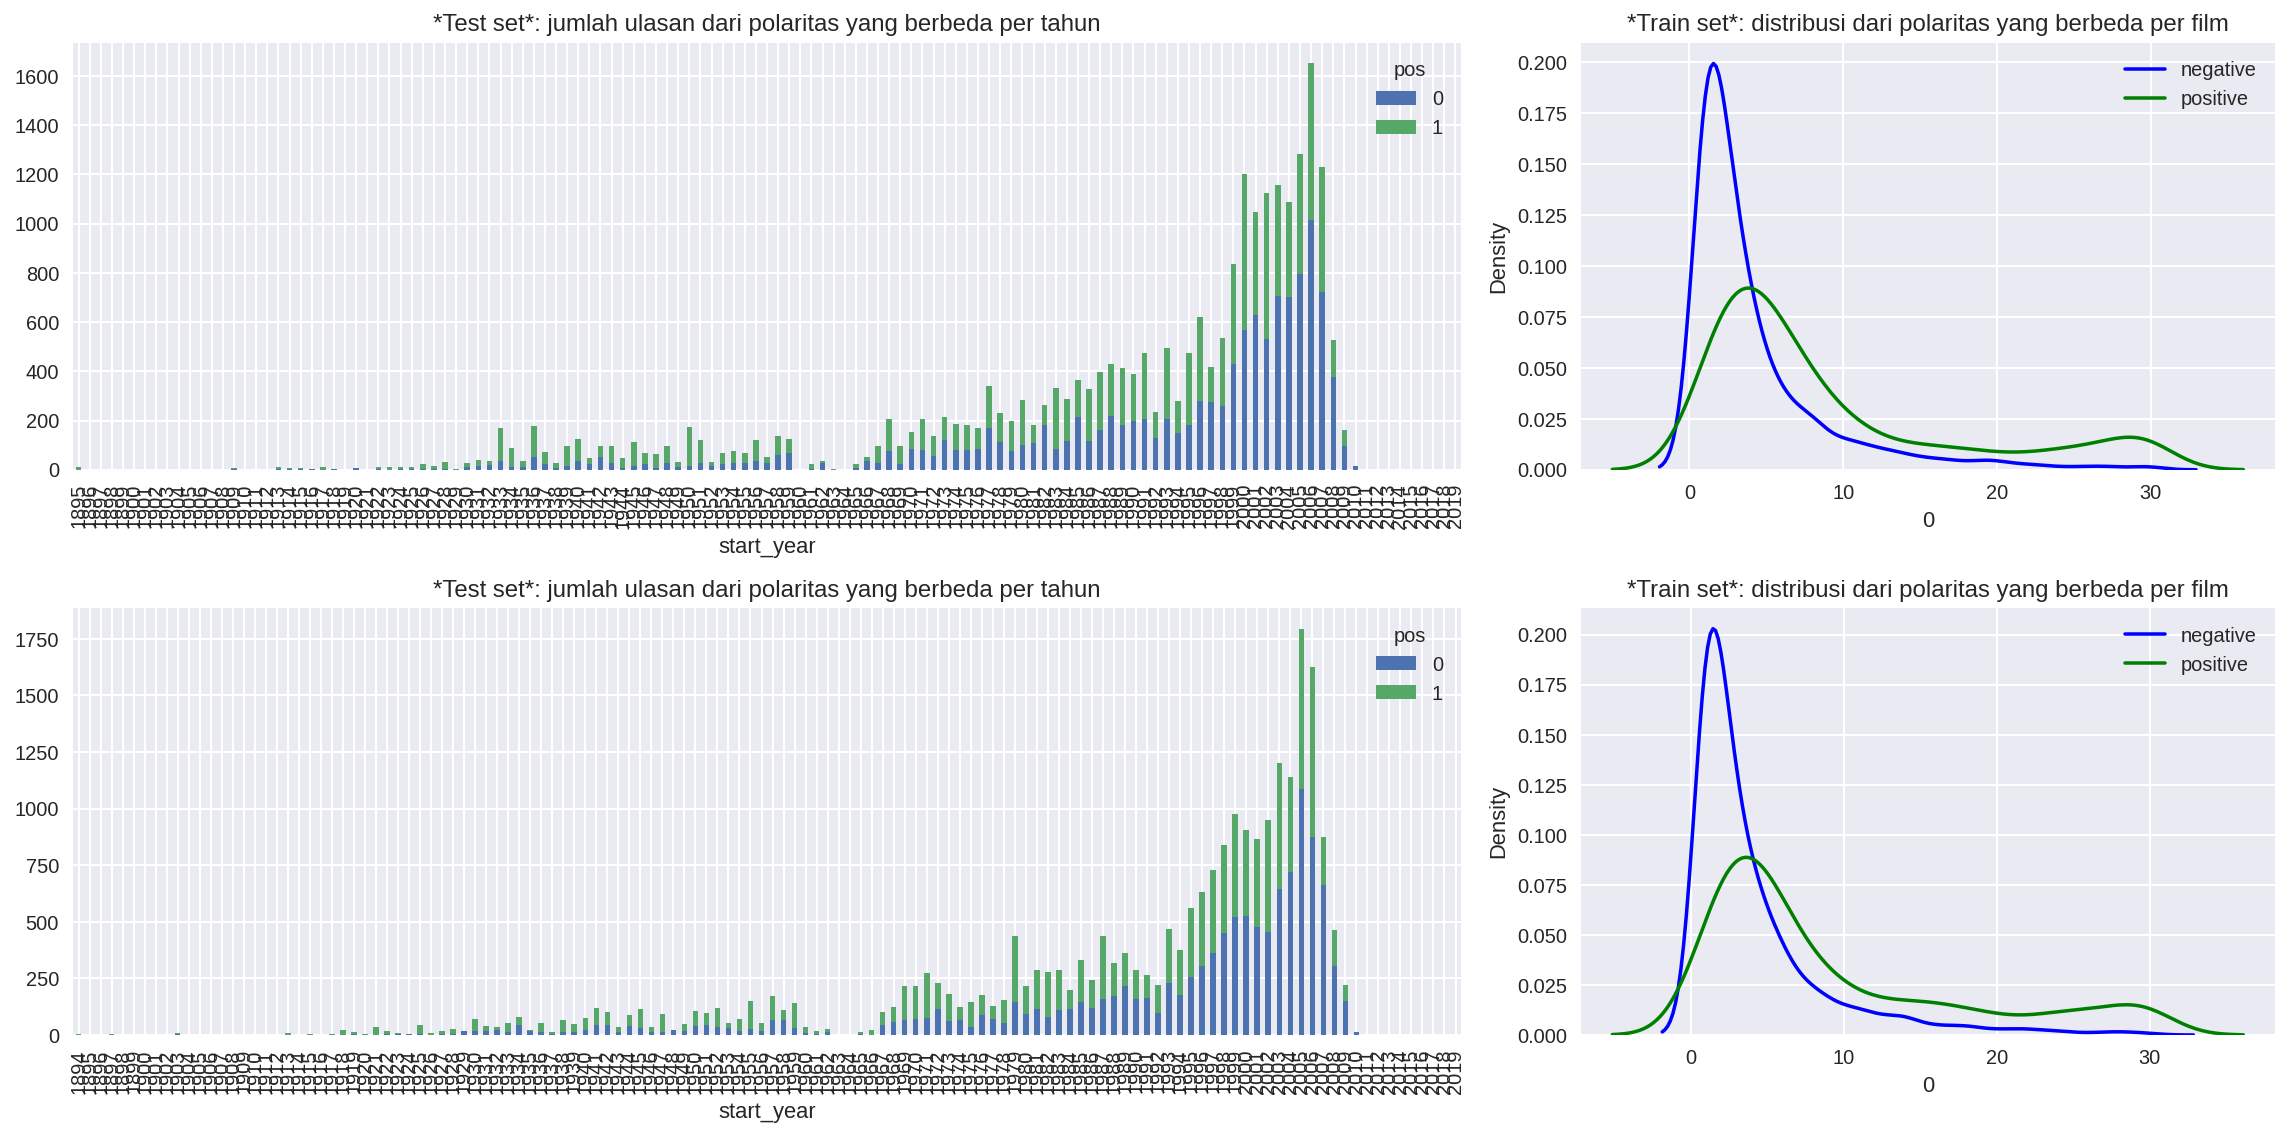

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

If you look at the graph above, negative ratings still dominate compared to positive ratings.

## Evaluation Procedure

Compile evaluations that can be used for all models in this task on a regular basis

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisation

We assume all models below accept text in lowercase and without numbers, punctuation, etc.

In [17]:
df_reviews['review_norm']=df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())
df_reviews['review_norm']=df_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))
df_reviews['review_norm'].head(10)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
5    this is the first movie i ve seen from singapo...
6    yes non singaporean s can t see what s the big...
7    this true story of carlson s raiders is more o...
8    should have been titled balderdash little in t...
9    the movie gung ho the story of carlson s makin...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the entire *dataset* is already split into *train/test*. The appropriate flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Work with Model

### Model 0 - Konstan

In [19]:
from sklearn.dummy import DummyClassifier
stop=set(stopwords.words('english'))


In [20]:
#feature menggunakan lemmatization
f_train0=[]
f_test0=[]
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_train0.append(l_join) 

for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop]
    lemmas = [lemmatizer.lemmatize(r) for r in result]
    l_join = " ".join(lemmas)
    f_test0.append(l_join)

#training model    
model=DummyClassifier().fit(f_train0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


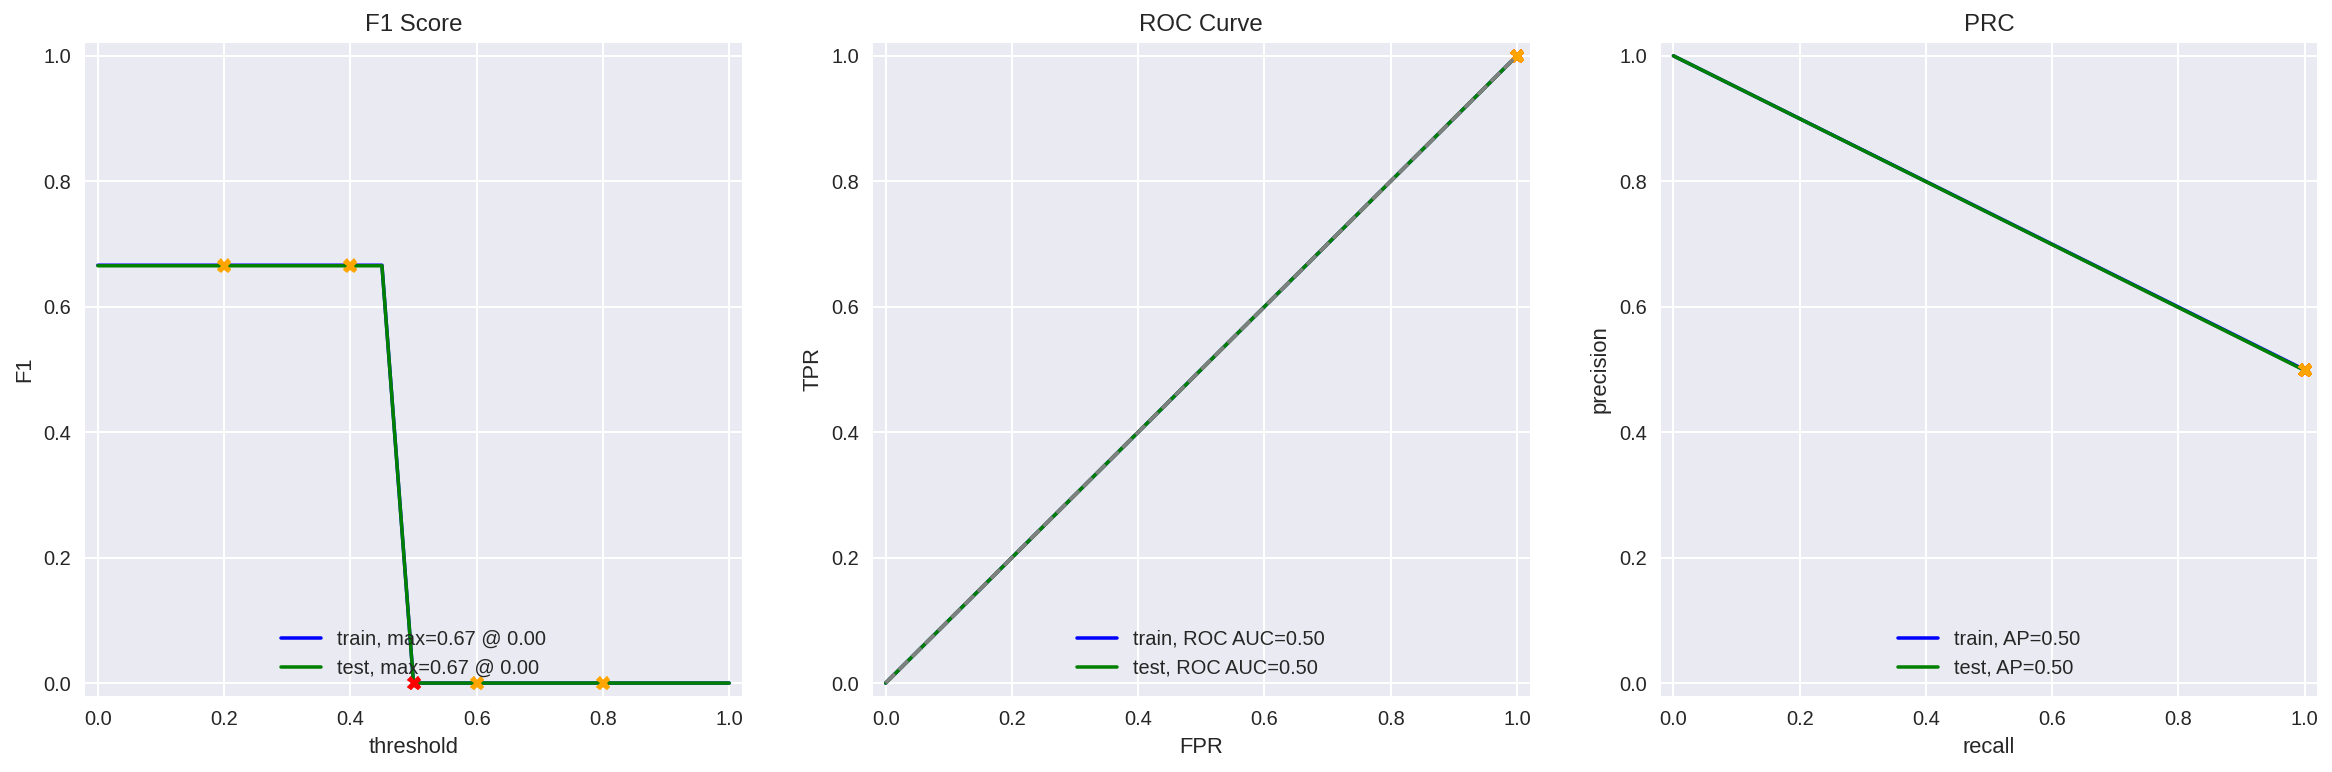

In [21]:
# Evaluasi model menggunakan fungsi evaluate_model
evaluate_model(model, f_train0, train_target, f_test0, test_target)

The F1 Score value from the test data is 0.

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [22]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [23]:
def text_preprocessing_3(text):
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Lemmatisasi
    lemmas = [lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stop]
    
    # Menggabungkan kata menjadi teks
    processed_text = " ".join(lemmas)
    
    return processed_text

# penggunaan pada DataFrame
df_reviews_train['review_token'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))
df_reviews_test['review_token'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

# penggunaan pada corpus
corpus_train = [text_preprocessing_3(text) for text in df_reviews_train['review_norm']]
corpus_test = [text_preprocessing_3(text) for text in df_reviews_test['review_norm']]

In [24]:
tfidf_vectorizer_2=TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1,1))
train_features_1 = tfidf_vectorizer_2.fit_transform(corpus_train)
test_features_1 = tfidf_vectorizer_2.transform(corpus_test)

In [25]:
model_1 = LogisticRegression(C=0.5).fit(train_features_1, train_target)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


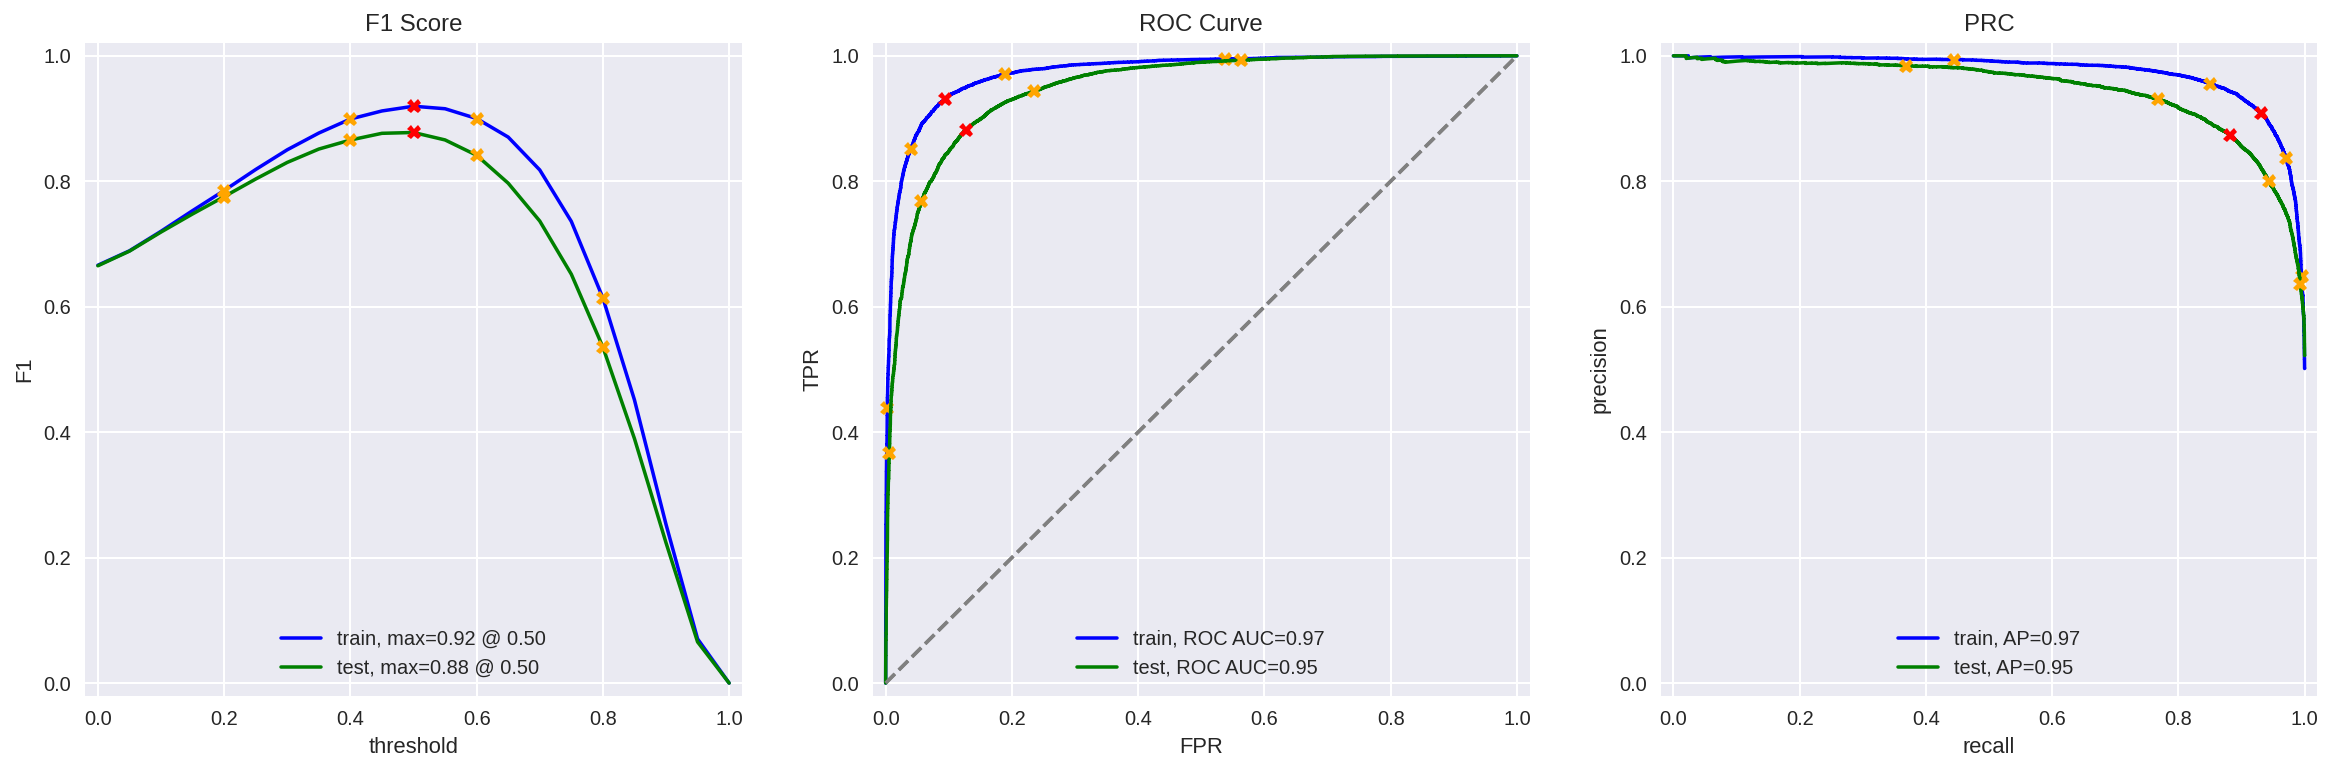

In [26]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The F1 SCORE value for the test data is 0.88 which is better than before.

### Model 3 - spaCy, TF-IDF and LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
# Menambahkan kolom 'review_token' ke DataFrame menggunakan apply
df_reviews_train['review_token'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))
df_reviews_test['review_token'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

# Vektorisasi corpus
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True, ngram_range=(1, 1))

f_train3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_token'])
f_test3 = tfidf_vectorizer_3.transform(df_reviews_test['review_token'])

In [30]:
#Melatih model
model_3=LogisticRegression(C=0.5).fit(f_train3, train_target)

          train  test
Accuracy   0.91  0.88
F1         0.92  0.88
APS        0.97  0.94
ROC AUC    0.97  0.95


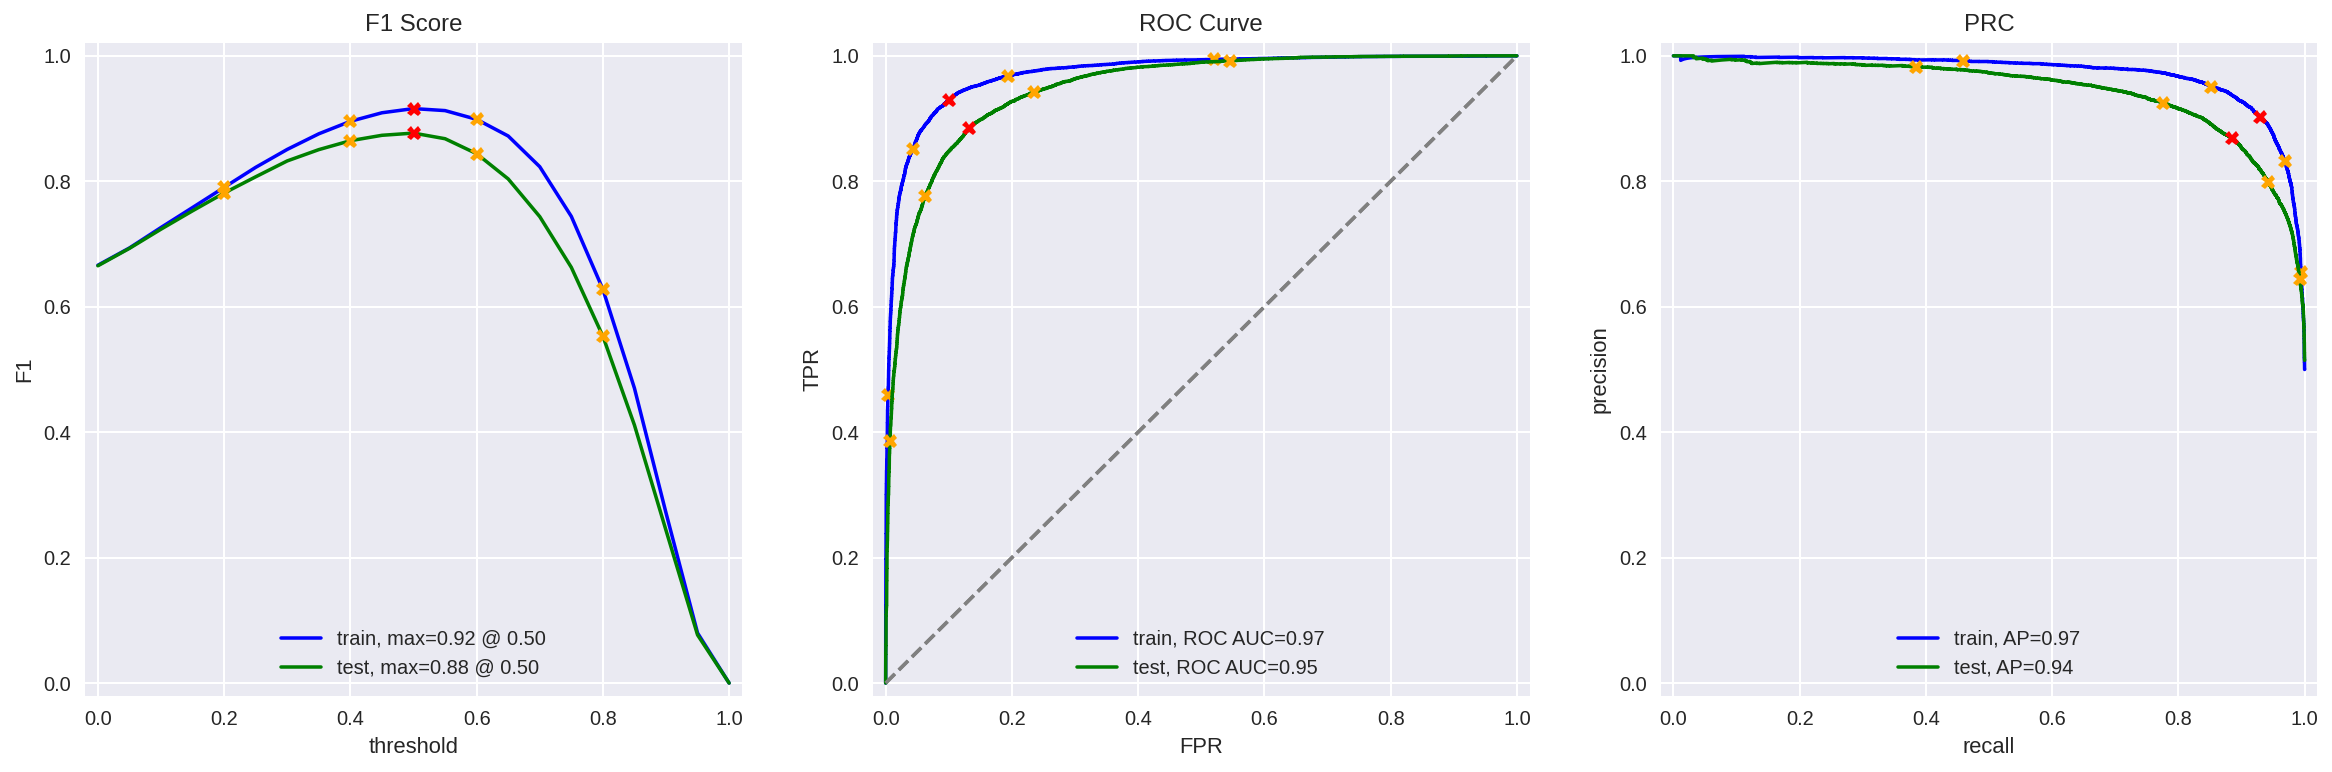

In [31]:
#Mengevaluasi model
evaluate_model(model_3, f_train3, train_target, f_test3, test_target)

The F1 SCORE value is 0.88 for test data.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [33]:
#Mencari parameter terbaik untuk model LightGBM Classifier
model=LGBMClassifier()
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[12345]}
grid=GridSearchCV(estimator=model, param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train3, train_target)
best_param=grid.best_params_

print('Best score from searched params:', grid.best_score_)
print('Best parameters:', best_param)

Best score from searched params: 0.8344031036284565
Best parameters: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 20, 'objective': 'binary', 'random_state': 12345}


In [34]:
model_4=LGBMClassifier(num_leaves=best_param['num_leaves'],
                      learning_rate=best_param['learning_rate'],
                      n_estimators=best_param['n_estimators'],
                      objective='binary',
                      random_state=12345)
model_4.fit(f_train3, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=20,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.87  0.84
F1         0.88  0.84
APS        0.95  0.92
ROC AUC    0.95  0.92


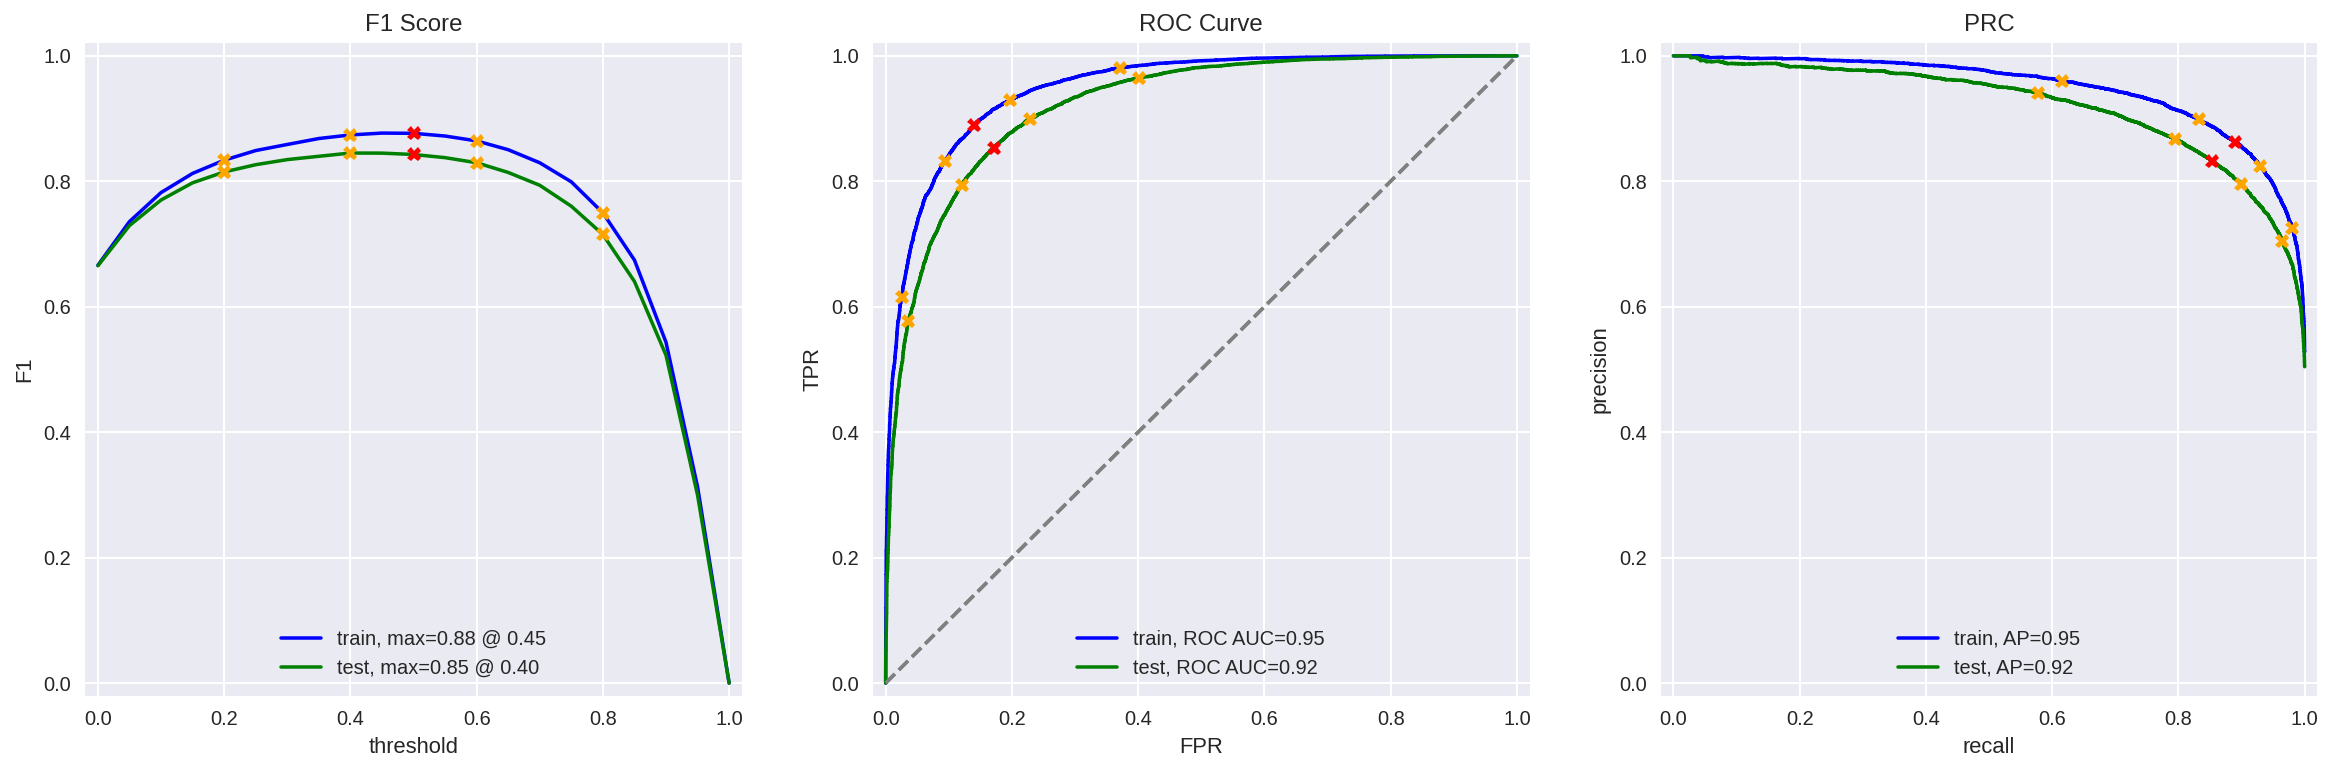

In [35]:
evaluate_model(model_4, f_train3, train_target, f_test3, test_target)

The F1 SCORE value for the test data decreased to 0.84.

## Review

In [36]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja 
my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).lower())
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: " ".join(word_tokenize(x)))

my_reviews

,review,review_norm
0,"saya tidak begitu menyukainya, bukan jenis fil...",saya tidak begitu menyukainya bukan jenis film...
1,"Membosankan, bahkan saya tidur di tengah-tenga...",membosankan bahkan saya tidur di tengah tengah...
2,"Filmnya sangat bagus, saya sangat suka",filmnya sangat bagus saya sangat suka
3,Bahkan para aktornya terlihat sangat tua dan t...,bahkan para aktornya terlihat sangat tua dan t...
4,Saya tidak menyangka filmnya sebagus ini! Para...,saya tidak menyangka filmnya sebagus ini para ...
5,"Film ini memiliki kelebihan dan kekurangan, te...",film ini memiliki kelebihan dan kekurangan tet...
6,Beberapa lawakannya sungguh tidak lucu. Tidak ...,beberapa lawakannya sungguh tidak lucu tidak a...
7,Menayangkan film ini di Netflix adalah langkah...,menayangkan film ini di netflix adalah langkah...


### Model 2

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.67:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.52:  membosankan bahkan saya tidur di tengah tengah film
0.49:  filmnya sangat bagus saya sangat suka
0.50:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.48:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.56:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.44:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.63:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 3

In [38]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.53:  membosankan bahkan saya tidur di tengah tengah film
0.50:  filmnya sangat bagus saya sangat suka
0.49:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.48:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.55:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.44:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.62:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 4

In [39]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.64:  membosankan bahkan saya tidur di tengah tengah film
0.64:  filmnya sangat bagus saya sangat suka
0.64:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.64:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.64:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.64:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.71:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


## Kesimpulan

1. Kita telah mengecek data aslinya dan terdapat nilai yang hilang dan kita melakukan dropna karena hanya sedikit data sehingga tidak masalah.
2. Berdasarkan diagram, secara keseluruhan jumlah film mengalami peningkatan tiap tahunnya dan tertinggi pada tahun 2006 kemudian turun kembali. Begitupun dengan jumlah review filmnya juga puncaknya terjadi pada tahun 2006.
3. Berdasarkan diagram kita juga bisa melihat bahwa ulasan film negatif masih mendominasi tiap tahunnya daripada ulasan film positif.
4. Setelah dilakukan pemodelan untuk memprediksi apakah ulasan berisi positif atau negatif, model terbaik adalah Logistic Regression dengan menggunakan NLTK dan TF-IDF Vectorisasi dimana F1 SCOREnya 0.88.
5. Kita tidak melakukan model BERT dikarenakan kendala komputer.